[*********************100%%**********************]  1 of 1 completed

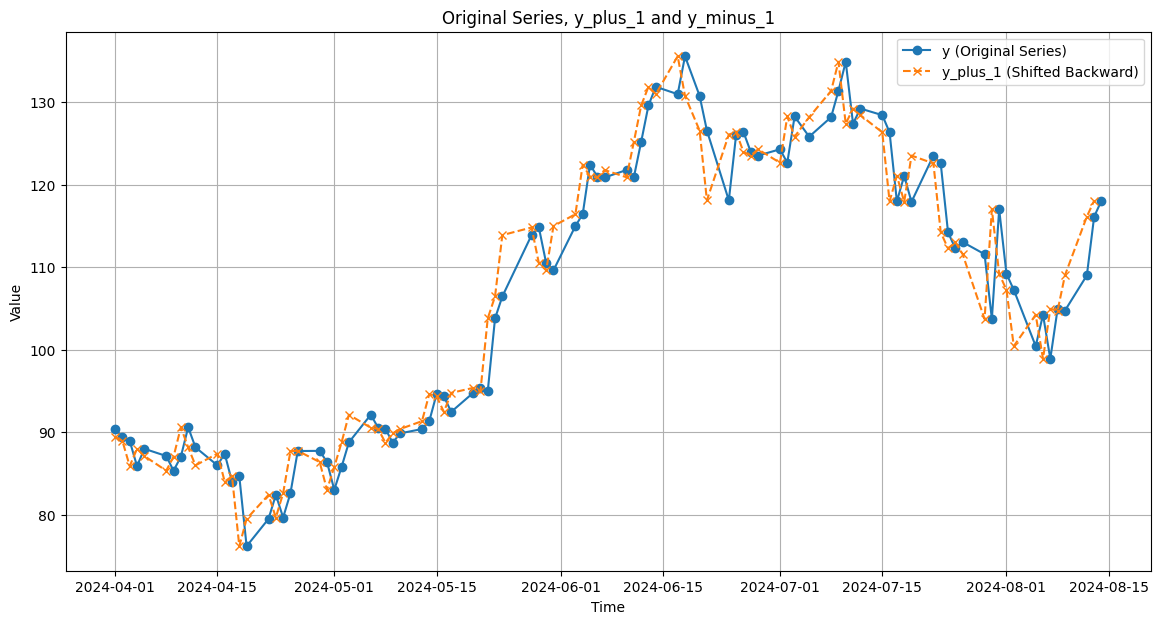

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm

# # Generate synthetic AR(p) series
# np.random.seed(123)
# ar_params = np.array([1, -0.5, 0.25])
# ma_params = np.array([1])
# ar_process = ArmaProcess(ar_params, ma_params)
# synthetic_ar_data = ar_process.generate_sample(nsample=50)
# synthetic_ar_series = pd.Series(synthetic_ar_data)
# synthetic_ar_series = synthetic_ar_series + 10

import yfinance as yf
from datetime import datetime
ticker = 'NVDA'
data = yf.download(ticker, start='2024-04-01', end=datetime.today().strftime('%Y-%m-%d'))
y = data.Close

# Create y, y_plus_1, and y_minus_1
# y = synthetic_ar_series
y_plus_1 = y.shift(-1)
y_minus_1 = y.shift(1)

# Plot the series
plt.figure(figsize=(14, 7))

plt.plot(y, label='y (Original Series)', marker='o')
plt.plot(y_plus_1, label='y_plus_1 (Shifted Backward)', linestyle='--', marker='x')
# plt.plot(y_minus_1, label='y_minus_1 (Shifted Forward)', linestyle=':', marker='s')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Series, y_plus_1 and y_minus_1')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Prepare data for linear regression (drop NaN values due to shifting)
df = pd.DataFrame({'y_plus_1': y_plus_1,
                   'y': y,
                   'y_minus_1': y_minus_1
                   }).dropna()

display(df.head())

# Perform linear regression
X = df[['y_minus_1', 'y_plus_1']]
X = sm.add_constant(X)
model = sm.OLS(df['y'], X)
results = model.fit()

# # Print the regression results
# print(results.summary())

,y_plus_1,y,y_minus_1
Date,,,
2024-04-02,88.963997,89.452003,90.362999
2024-04-03,85.904999,88.963997,89.452003
2024-04-04,88.008003,85.904999,88.963997
2024-04-05,87.133003,88.008003,85.904999
2024-04-08,85.353996,87.133003,88.008003


In [6]:
print(results.params)

const        0.544638
y_minus_1    0.497970
y_plus_1     0.496783
dtype: float64


In [7]:
print(results.params)
phi_0 = results.params['const']
phi_1 = results.params['y_minus_1']
alfa_1 = results.params['y_plus_1']
print(f'\nphi_0: {phi_0:.7}\nphi_1: {phi_1:.7}\nalfa_1: {alfa_1:.7}')

const        0.544638
y_minus_1    0.497970
y_plus_1     0.496783
dtype: float64

phi_0: 0.5446378
phi_1: 0.4979697
alfa_1: 0.4967826


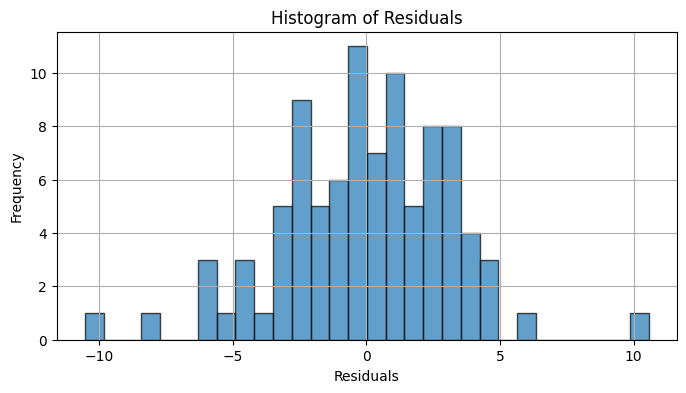

In [8]:
import matplotlib.pyplot as plt

# Assuming results is already defined and contains the residuals
residuals = results.resid

# Plotting the histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
# Perform linear regression
X_2 = df[['y_minus_1']]
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(df['y'], X_2)
results_2 = model_2.fit()

# # Print the regression results
# print(results_2.summary())

In [10]:
print(results_2.params)
theta_0 = results_2.params['const']
theta_1 = results_2.params['y_minus_1']
print(f'\ntheta_0: {theta_0:.7}\ntheta_1: {theta_1:.7}')

const        3.650989
y_minus_1    0.968276
dtype: float64

theta_0: 3.650989
theta_1: 0.9682759


In [11]:
print(phi_0 / (1 - (2*alfa_1)))
print(theta_0)
print((phi_1 - alfa_1) / (1 - (2*alfa_1)))
print(theta_1)

84.64048799521336
3.650988972177153
0.18447500683152718
0.9682759112987482


In [14]:
y_rebuild = phi_0 + (phi_1 * y_minus_1) + (alfa_1 * y_plus_1) + results.resid

y_btf = results.predict(X)

t_1 = phi_0 / (1 - (2*alfa_1))
t_2 = (phi_1 - alfa_1) / (1 - (2*alfa_1))
t_3 = 1 - (2*alfa_1)

#y_btf_reb = t_1 + (t_2 * y_minus_1) + (results.resid / t_3)
y_btf_reb = t_1 + (t_2 * y_minus_1) + results.resid

all_models = pd.DataFrame({
                      'y': y,
                    #   'y_rebuild': y_rebuild,
                      'y_btf': y_btf,
                      # 'y_btf_reb': y_btf_reb,
                      })

display(all_models.head())
display(all_models.tail())

,y,y_btf
Date,,
2024-04-01,90.362999,NaN
2024-04-02,89.452003,89.738441
2024-04-03,88.963997,87.765136
2024-04-04,85.904999,88.566860
2024-04-05,88.008003,86.608886


,y,y_btf
Date,,
2024-08-08,104.970001,101.836803
2024-08-09,104.750000,106.975758
2024-08-12,109.019997,110.403298
2024-08-13,116.139999,113.493386
2024-08-14,118.080002,NaN


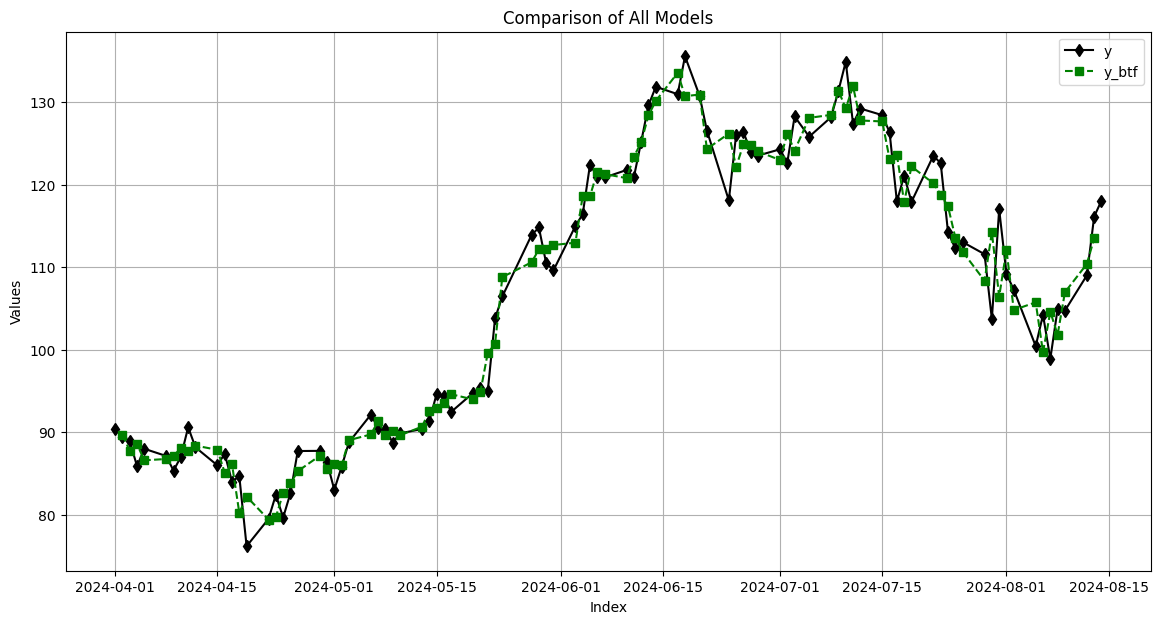

In [15]:
import matplotlib.pyplot as plt

# Define custom styles for each series
styles = {
    'y_rebuild': {'linestyle': '-', 'color': 'blue', 'marker': 'o'},
    'y_btf': {'linestyle': '--', 'color': 'green', 'marker': 's'},
    'y_btf_reb': {'linestyle': '-.', 'color': 'red', 'marker': 'x'},
    'y': {'linestyle': '-', 'color': 'black', 'marker': 'd'}
}

# Plot all series in the same graph with custom styles
plt.figure(figsize=(14, 7))

for column in all_models.columns:
    plt.plot(all_models[column], 
             linestyle=styles[column]['linestyle'], 
             color=styles[column]['color'], 
             marker=styles[column]['marker'], 
             label=column)

# Add title and labels
plt.title('Comparison of All Models')
plt.xlabel('Index')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()
